# Подготовка окружения

In [1]:
import sys
sys.path.append("./venv/Scripts")
sys.path.append("./venv")
sys.path.append("./venv/Lib")
sys.path.append("./venv/Lib/site-packages")

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import bnlearn

In [3]:
from network import BayesNetwork
from node import BayesNode

# Загрузка данных

Датасет взят с [kaggle](https://www.kaggle.com/datasets/asgharalikhan/mortality-rate-heart-patient-pakistan-hospital/data)

In [4]:
df = pd.read_csv("FIC.Full CSV.csv")
df = df.rename(
    columns={
        'Locality  ': 'Locality',
        'Marital status                       ': 'Marital status',
        'Life.Style                                                                              ': 'Life.Style',
        'Others ': 'Others',
    }
)
df.head()

,Age,Age.Group,Gender,Locality,Marital status,Life.Style,Sleep,Category,Depression,Hyperlipi,...,oldpeak,slope,ca,thal,num,SK,SK.React,Reaction,Mortality,Follow.Up
0,45,41-50,Female,RURAL,MARRIED,NO,NO,FREE,YES,YES,...,3.0,2,0,7,2,1,NO,0,0,60
1,51,51-60,Female,URBAN,MARRIED,NO,NO,FREE,YES,YES,...,1.2,2,0,7,2,1,NO,0,0,15
2,55,51-60,Female,RURAL,MARRIED,YES,YES,FREE,YES,YES,...,3.4,2,0,3,2,1,NO,0,0,6
3,55,51-60,Female,RURAL,MARRIED,YES,YES,FREE,YES,YES,...,2.0,2,1,7,3,1,NO,0,0,52
4,56,51-60,Female,RURAL,MARRIED,YES,NO,FREE,YES,YES,...,4.0,3,2,7,3,1,NO,0,0,34


## Анализ данных

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 368 entries, 0 to 367
Data columns (total 60 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Age               368 non-null    int64  
 1   Age.Group         368 non-null    object 
 2   Gender            368 non-null    object 
 3   Locality          368 non-null    object 
 4   Marital status    368 non-null    object 
 5   Life.Style        368 non-null    object 
 6   Sleep             368 non-null    object 
 7   Category          368 non-null    object 
 8   Depression        368 non-null    object 
 9   Hyperlipi         368 non-null    object 
 10  Smoking           368 non-null    object 
 11  Family.History    368 non-null    object 
 12  F.History         368 non-null    int64  
 13  Diabetes          368 non-null    int64  
 14  HTN               368 non-null    object 
 15  Allergies         368 non-null    object 
 16  BP                368 non-null    float64
 1

Пропущенных значений нет

In [6]:
df.columns

Index(['Age', 'Age.Group', 'Gender', 'Locality', 'Marital status',
       'Life.Style', 'Sleep', 'Category', 'Depression', 'Hyperlipi', 'Smoking',
       'Family.History', 'F.History', 'Diabetes', 'HTN', 'Allergies', 'BP',
       'Thrombolysis', 'BGR', 'B.Urea', 'S.Cr', 'S.Sodium', 'S.Potassium',
       'S.Chloride', 'C.P.K', 'CK.MB', 'ESR', 'WBC', 'RBC', 'Hemoglobin',
       'P.C.V', 'M.C.V', 'M.C.H', 'M.C.H.C', 'PLATELET_COUNT', 'NEUTROPHIL',
       'LYMPHO', 'MONOCYTE', 'EOSINO', 'Others', 'CO', 'Diagnosis',
       'Hypersensitivity', 'cp', 'trestbps', 'chol', 'fbs', 'restecg',
       'thalach', 'exang', 'oldpeak', 'slope', 'ca', 'thal', 'num', 'SK',
       'SK.React', 'Reaction', 'Mortality', 'Follow.Up'],
      dtype='object')

In [7]:
object_columns = [
    "Age.Group", 
    "Gender", 
    "Locality", 
    "Marital status", 
    "Life.Style",
    "Sleep", 
    "Category", 
    "Depression", 
    "Hyperlipi", 
    "Smoking",
    "Family.History",
    "Others",
    "CO",
    "Diagnosis",
    "Hypersensitivity",
    "SK.React"
]
df[object_columns].head()

,Age.Group,Gender,Locality,Marital status,Life.Style,Sleep,Category,Depression,Hyperlipi,Smoking,Family.History,Others,CO,Diagnosis,Hypersensitivity,SK.React
0,41-50,Female,RURAL,MARRIED,NO,NO,FREE,YES,YES,NO,NO,no,"Chest pain,",EXT. ACUTE WALL M.I,NO,NO
1,51-60,Female,URBAN,MARRIED,NO,NO,FREE,YES,YES,NO,NO,no,"Central Chest pain,",A/W M.I,NO,NO
2,51-60,Female,RURAL,MARRIED,YES,YES,FREE,YES,YES,NO,NO,LV dysfunction,"Chest pain,SOB, Cold sweating",AC I/W M.I (RV) RE. M.I,NO,NO
3,51-60,Female,RURAL,MARRIED,YES,YES,FREE,YES,YES,NO,NO,HTN,"CENTRAL Chest pain,",I/W M.I,NO,NO
4,51-60,Female,RURAL,MARRIED,YES,NO,FREE,YES,YES,NO,NO,no,"Chest pain,",A/W M.I,NO,NO


In [8]:
for col in object_columns:
    print(f"{col} unique", len(df[col].unique()))

Age.Group unique 5
Gender unique 2
Locality unique 2
Marital status unique 2
Life.Style unique 2
Sleep unique 2
Category unique 2
Depression unique 2
Hyperlipi unique 2
Smoking unique 2
Family.History unique 2
Others unique 17
CO unique 37
Diagnosis unique 37
Hypersensitivity unique 2
SK.React unique 7


In [9]:
binary_columns = [
    "Gender", 
    "Locality", 
    "Marital status", 
    "Life.Style",
    "Sleep", 
    "Category", 
    "Depression", 
    "Hyperlipi", 
    "Smoking",
    "Family.History",
    "Hypersensitivity",
]

In [10]:
cat_df = df.copy()
le = LabelEncoder()
cat_df["Age.Group"] = le.fit_transform(df["Age.Group"])
cat_df["CO"] = le.fit_transform(df["CO"])
cat_df["Diagnosis"] = le.fit_transform(df["Diagnosis"])
cat_df["SK.React"] = le.fit_transform(df["SK.React"])
dummied_df = pd.get_dummies(df[binary_columns], drop_first=True)
cat_df = cat_df.drop(columns=binary_columns + ["Age", "Others"])
cat_df = pd.concat([cat_df, dummied_df], axis=1)
cat_df.head()

,Age.Group,F.History,Diabetes,HTN,Allergies,BP,Thrombolysis,BGR,B.Urea,S.Cr,...,Locality_URBAN,Marital status_SINGLE,Life.Style_YES,Sleep_YES,Category_PAID,Depression_YES,Hyperlipi_YES,Smoking_YES,Family.History_YES,Hypersensitivity_YES
0,2,0,1,NO,NO,100.6,0,84,28.0,0.9,...,False,False,False,False,False,True,True,False,False,False
1,3,0,0,NO,NO,90.6,0,135,17.0,0.7,...,True,False,False,False,False,True,True,False,False,False
2,3,0,1,YES,NO,100.7,0,146,37.0,1.0,...,False,False,True,True,False,True,True,False,False,False
3,3,0,1,YES,NO,160.1,0,146,37.0,1.0,...,False,False,True,True,False,True,True,False,False,False
4,3,0,1,YES,NO,90.6,0,85,78.0,1.2,...,False,False,True,False,False,True,True,False,False,False


In [11]:
cat_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 368 entries, 0 to 367
Data columns (total 58 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Age.Group              368 non-null    int32  
 1   F.History              368 non-null    int64  
 2   Diabetes               368 non-null    int64  
 3   HTN                    368 non-null    object 
 4   Allergies              368 non-null    object 
 5   BP                     368 non-null    float64
 6   Thrombolysis           368 non-null    int64  
 7   BGR                    368 non-null    int64  
 8   B.Urea                 368 non-null    float64
 9   S.Cr                   368 non-null    float64
 10  S.Sodium               368 non-null    int64  
 11  S.Potassium            368 non-null    float64
 12  S.Chloride             368 non-null    int64  
 13  C.P.K                  368 non-null    int64  
 14  CK.MB                  368 non-null    int64  
 15  ESR   

In [12]:
for col in cat_df.columns:
    print(f"{col} unique", len(cat_df[col].unique()))


Age.Group unique 5
F.History unique 2
Diabetes unique 2
HTN unique 2
Allergies unique 2
BP unique 17
Thrombolysis unique 2
BGR unique 38
B.Urea unique 28
S.Cr unique 13
S.Sodium unique 17
S.Potassium unique 15
S.Chloride unique 14
C.P.K unique 44
CK.MB unique 31
ESR unique 22
WBC unique 31
RBC unique 32
Hemoglobin unique 32
P.C.V unique 19
M.C.V unique 27
M.C.H unique 22
M.C.H.C unique 8
PLATELET_COUNT unique 36
NEUTROPHIL unique 27
LYMPHO unique 24
MONOCYTE unique 8
EOSINO unique 5
CO unique 37
Diagnosis unique 37
cp unique 4
trestbps unique 39
chol unique 97
fbs unique 2
restecg unique 3
thalach unique 71
exang unique 2
oldpeak unique 35
slope unique 3
ca unique 4
thal unique 3
num unique 4
SK unique 2
SK.React unique 7
Reaction unique 2
Mortality unique 2
Follow.Up unique 22
Gender_Male unique 2
Locality_URBAN unique 2
Marital status_SINGLE unique 2
Life.Style_YES unique 2
Sleep_YES unique 2
Category_PAID unique 2
Depression_YES unique 2
Hyperlipi_YES unique 2
Smoking_YES unique 2
F

In [13]:
num_columns = [
    "BP",
    "BGR",
    "B.Urea",
    "S.Cr",
    "S.Sodium",
    "S.Potassium",
    "S.Chloride",
    "C.P.K",
    "CK.MB",
    "ESR",
    "WBC",
    "RBC",
    "Hemoglobin",
    "P.C.V",
    "M.C.V",
    "M.C.H",
    "PLATELET_COUNT",
    "NEUTROPHIL",
    "LYMPHO",
    "trestbps",
    "chol",
    "thalach",
    "oldpeak",
    "Follow.Up",    
]
q_df = cat_df.copy()
for col in num_columns:
    q_df[col] = pd.qcut(q_df[col], q=10, labels=False, duplicates="drop")
q_df

,Age.Group,F.History,Diabetes,HTN,Allergies,BP,Thrombolysis,BGR,B.Urea,S.Cr,...,Locality_URBAN,Marital status_SINGLE,Life.Style_YES,Sleep_YES,Category_PAID,Depression_YES,Hyperlipi_YES,Smoking_YES,Family.History_YES,Hypersensitivity_YES
0,2,0,1,NO,NO,1,0,0,1,1,...,False,False,False,False,False,True,True,False,False,False
1,3,0,0,NO,NO,0,0,3,0,0,...,True,False,False,False,False,True,True,False,False,False
2,3,0,1,YES,NO,2,0,3,5,2,...,False,False,True,True,False,True,True,False,False,False
3,3,0,1,YES,NO,7,0,3,5,2,...,False,False,True,True,False,True,True,False,False,False
4,3,0,1,YES,NO,0,0,0,8,4,...,False,False,True,False,False,True,True,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
363,3,0,0,YES,NO,4,1,7,5,0,...,True,False,False,False,False,True,False,False,False,False
364,3,0,0,NO,NO,3,0,8,0,3,...,False,False,True,False,False,True,True,True,False,False
365,3,0,1,YES,NO,6,0,1,0,0,...,True,False,False,False,False,True,True,False,False,False
366,3,0,0,YES,NO,4,0,3,7,2,...,True,False,False,False,False,True,True,True,False,False


# Обучение модели

[bnlearn] >Computing best DAG using [hc]
[bnlearn] >Set scoring type at [bic]
[bnlearn] >Compute structure scores for model comparison (higher is better).
[bnlearn] >Set node properties.
[bnlearn] >Set edge properties.
[bnlearn] >Plot based on Bayesian model
[bnlearn] >Warning: [graphviz_layout] layout not found. The layout [spring_layout] is used instead.


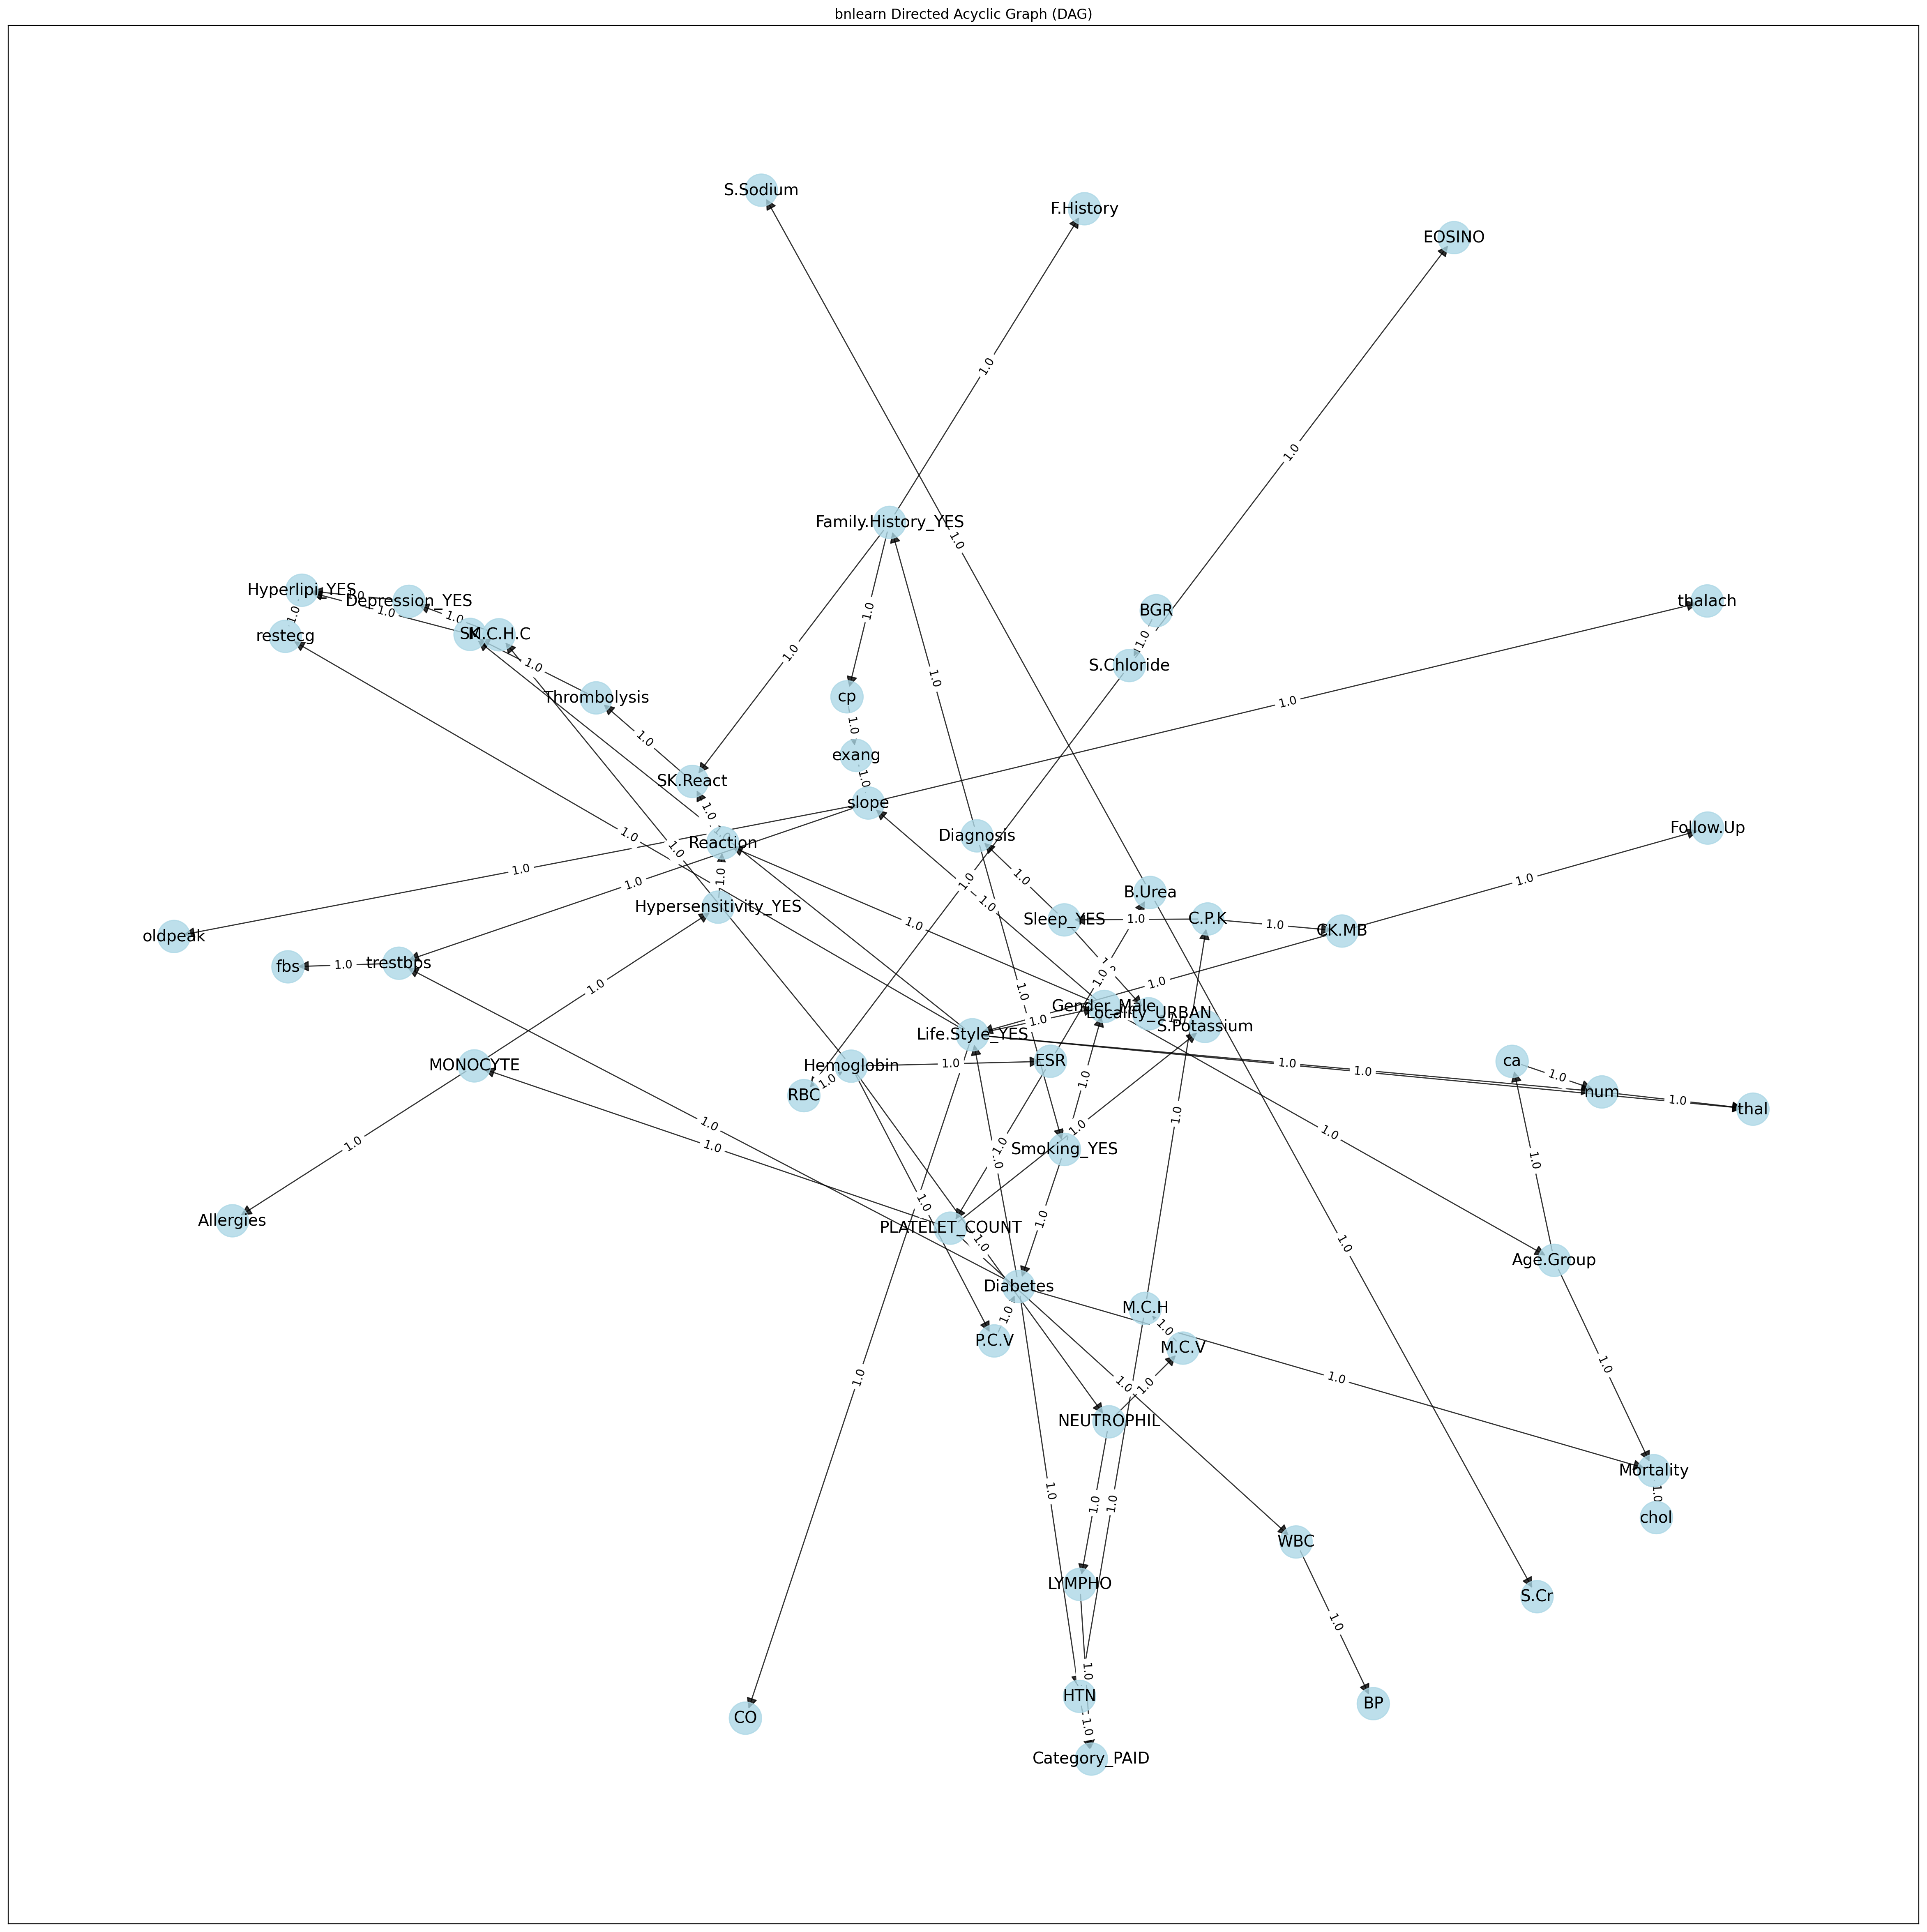

In [14]:
model = bnlearn.structure_learning.fit(q_df, methodtype='hc', scoretype='bic')

G = bnlearn.plot(model, params_static={'width':30, 'height':30})

[bnlearn] >Compute edge strength with [chi_square]
[bnlearn] >6 edges are removed with P-value > 0.05 based on chi_square
[bnlearn] >Converting source-target into adjacency matrix..
[bnlearn] >Making the matrix symmetric..
[bnlearn] >Set node properties.
[bnlearn]> Set edge weights based on the [chi_square] test statistic.
[bnlearn] >Converting source-target into adjacency matrix..
[bnlearn] >Making the matrix symmetric..
[bnlearn] >Converting source-target into adjacency matrix..
[bnlearn] >Making the matrix symmetric..
[bnlearn] >Set edge properties.
[bnlearn] >Plot based on Bayesian model
[bnlearn] >Warning: [graphviz_layout] layout not found. The layout [spring_layout] is used instead.


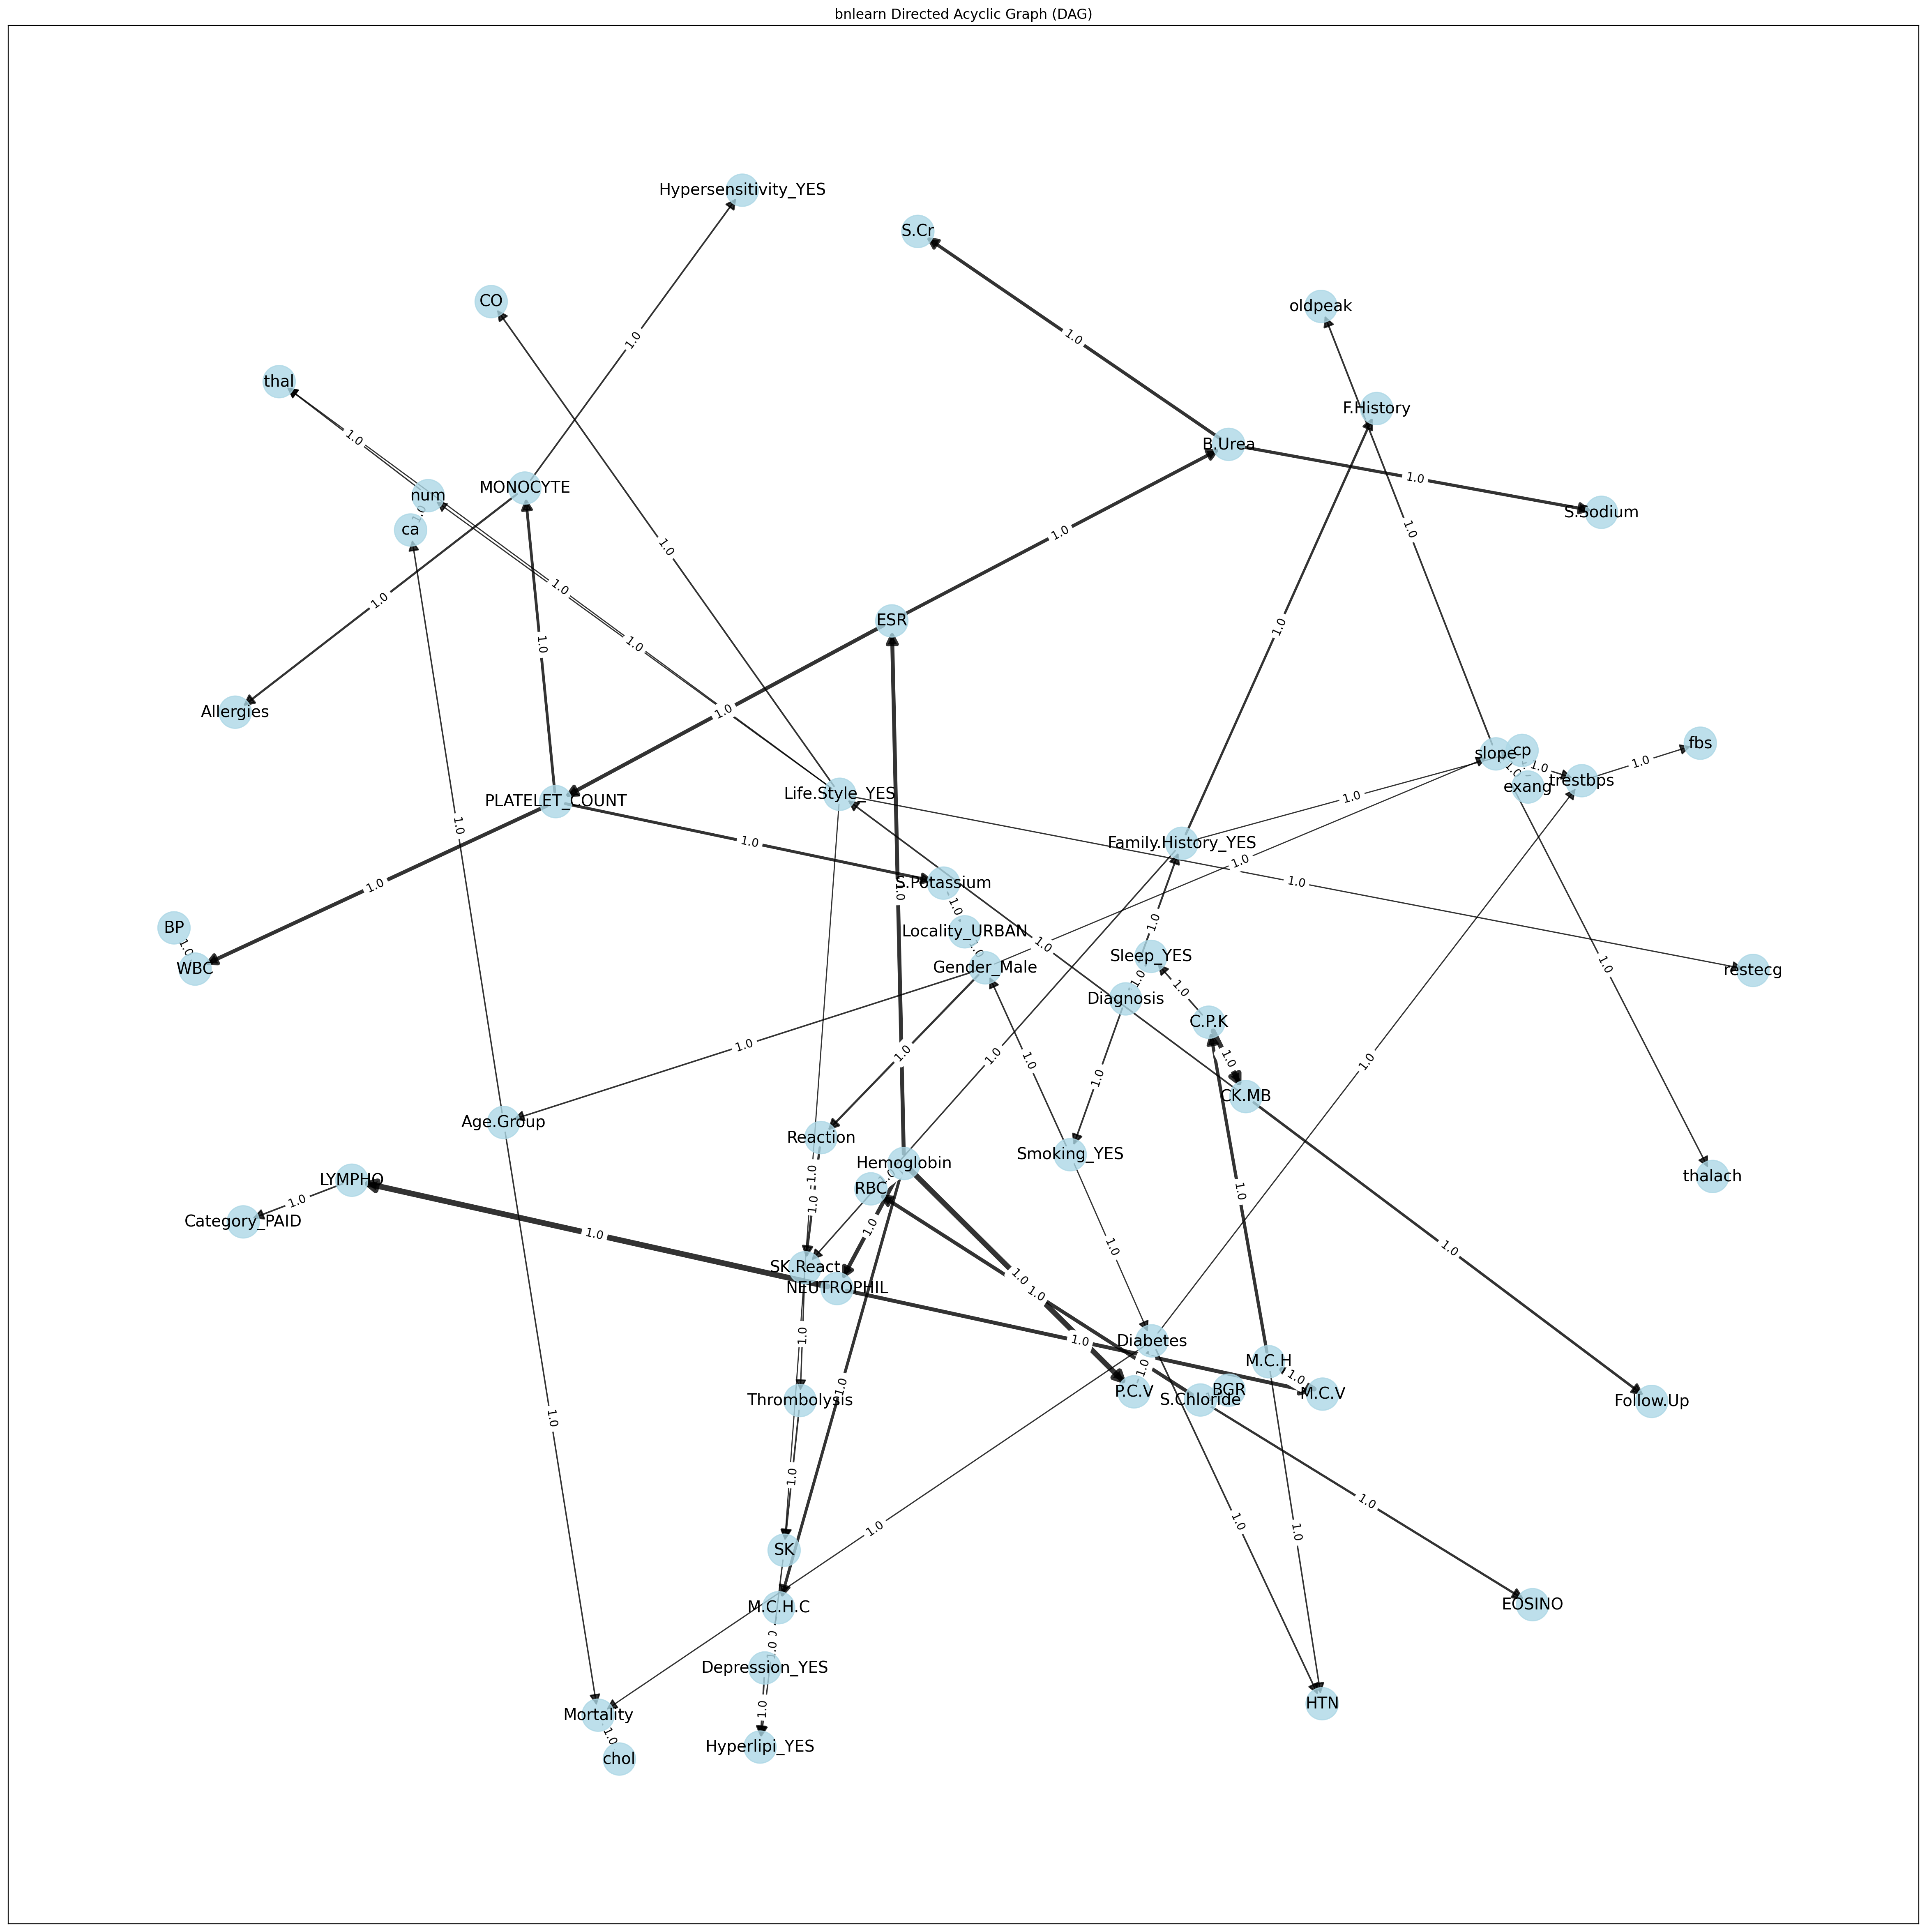

In [15]:
model = bnlearn.independence_test(model, q_df, alpha=0.05, prune=True)

G = bnlearn.plot(model, params_static={'width':30, 'height':30})

In [16]:
model = bnlearn.parameter_learning.fit(model, q_df, methodtype='maximumlikelihood')

[bnlearn] >Parameter learning> Computing parameters using [maximumlikelihood]
[bnlearn] >Converting [<class 'pgmpy.base.DAG.DAG'>] to BayesianNetwork model.
[bnlearn] >Converting adjmat to BayesianNetwork.
[bnlearn] >CPD of Age.Group:
+--------------+----------------------+---------------------+
| Gender_Male  | Gender_Male(False)   | Gender_Male(True)   |
+--------------+----------------------+---------------------+
| Age.Group(0) | 0.012048192771084338 | 0.03859649122807018 |
+--------------+----------------------+---------------------+
| Age.Group(1) | 0.0                  | 0.07017543859649122 |
+--------------+----------------------+---------------------+
| Age.Group(2) | 0.024096385542168676 | 0.20701754385964913 |
+--------------+----------------------+---------------------+
| Age.Group(3) | 0.24096385542168675  | 0.5754385964912281  |
+--------------+----------------------+---------------------+
| Age.Group(4) | 0.7228915662650602   | 0.10877192982456141 |
+--------------+-----

In [17]:
# Вероятность смерти людей от 50 до 60, с диабетом и депрессией
bnlearn.inference.fit(model, variables=['Mortality'], evidence={'Age.Group':3, 'Diabetes':1, 'Depression_YES':True})

[bnlearn] >Variable Elimination.
[bnlearn] >Warning: variable(s) [None] does not exists in DAG.
[bnlearn] >Data is stored in [query.df]
+----+-------------+-----------+
|    |   Mortality |         p |
+====+=============+===========+
|  0 |           0 | 0.958333  |
+----+-------------+-----------+
|  1 |           1 | 0.0416667 |
+----+-------------+-----------+


<DiscreteFactor representing phi(Mortality:2) at 0x203f254c290>

In [18]:
# Вероятность смерти курящих мужчин от 60 до 70, живущих в сельской местности 
bnlearn.inference.fit(model, variables=['Mortality'], evidence={'Age.Group':4, 'Locality_URBAN':False, 'Smoking_YES': True, 'Gender_Male': True})

[bnlearn] >Variable Elimination.
[bnlearn] >Warning: variable(s) [None] does not exists in DAG.
[bnlearn] >Data is stored in [query.df]
+----+-------------+----------+
|    |   Mortality |        p |
+====+=============+==========+
|  0 |           0 | 0.809456 |
+----+-------------+----------+
|  1 |           1 | 0.190544 |
+----+-------------+----------+


<DiscreteFactor representing phi(Mortality:2) at 0x203f2653d10>

In [19]:
# Вероятность смерти курящих мужчин от 60 до 70, живущих в городской местности 
bnlearn.inference.fit(model, variables=['Mortality'], evidence={'Age.Group':4, 'Locality_URBAN':True, 'Smoking_YES': True, 'Gender_Male': True})

[bnlearn] >Variable Elimination.
[bnlearn] >Warning: variable(s) [None] does not exists in DAG.
[bnlearn] >Data is stored in [query.df]
+----+-------------+----------+
|    |   Mortality |        p |
+====+=============+==========+
|  0 |           0 | 0.827785 |
+----+-------------+----------+
|  1 |           1 | 0.172215 |
+----+-------------+----------+


<DiscreteFactor representing phi(Mortality:2) at 0x203af382f10>